In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder ,LabelEncoder ,MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split ,GridSearchCV

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
# pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

:Attribute Information (in order):
- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per $10,000
- PTRATIO  pupil-teacher ratio by town
- B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT    % lower status of the population
- MEDV     Median value of owner-occupied homes in $1000's

：屬性資訊（依序）：
- CRIM 各城鎮人均犯罪率
- 面積超過 25,000 平方英尺的住宅用地的 ZN 比例。
- 每個城鎮非零售商業面積的 INDUS 比例
- CHAS Charles River 虛擬變數（如果區域邊界為河流，則 = 1；否則為 0）
- NOX一氧化氮濃度（千萬分之一）
- 每間住宅的平均房間數 RM
- 1940 年之前建造的自住單位的 AGE 比例
- 到五個波士頓就業中心的 DIS 加權距離
- RAD 放射狀高速公路可達性指數
- 每 10,000 美元的 TAX 全額財產稅稅率
- PTRATIO 各城鎮的師生比
- B 1000(Bk - 0.63)^2 其中 Bk 是按城鎮劃分的黑人比例
- LSTAT % 人口地位較低
- MEDV 自住房屋的中位數價值（1000 美元）

# EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/自主練習/Python學習筆記/boston_house_prices.csv')

df # 506 rows × 14 columns

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['ZN'])
plt.title('Boxplot of ZN')
plt.xlabel('ZN')
plt.ylabel('Values')
plt.show()

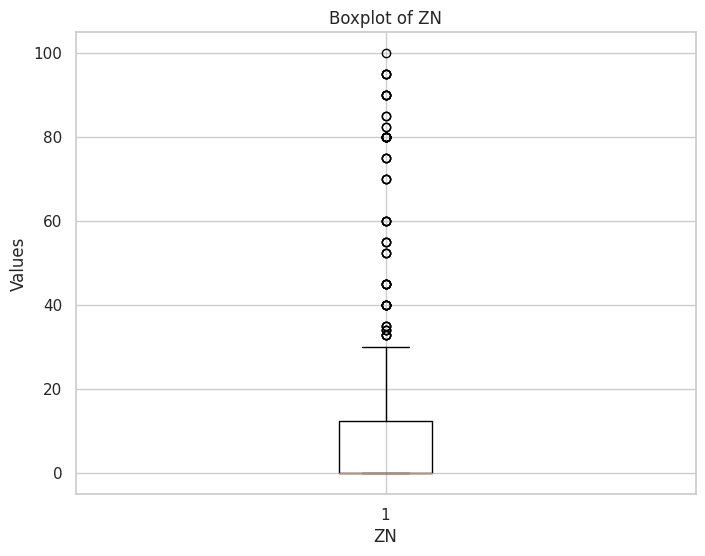

# Outlier

In [ ]:
mean_zn = df['ZN'].mean()
std_zn = df['ZN'].std()

upper_bound = mean_zn + 3 * std_zn
lower_bound = mean_zn - 3 * std_zn

df = df[(df['ZN'] >= lower_bound) & (df['ZN'] <= upper_bound)]

print("删除異常值後:", df.shape) # (492, 14)

In [ ]:
plt.figure(figsize=(8, 6))

sns.distplot(df['MEDV'])
plt.show()

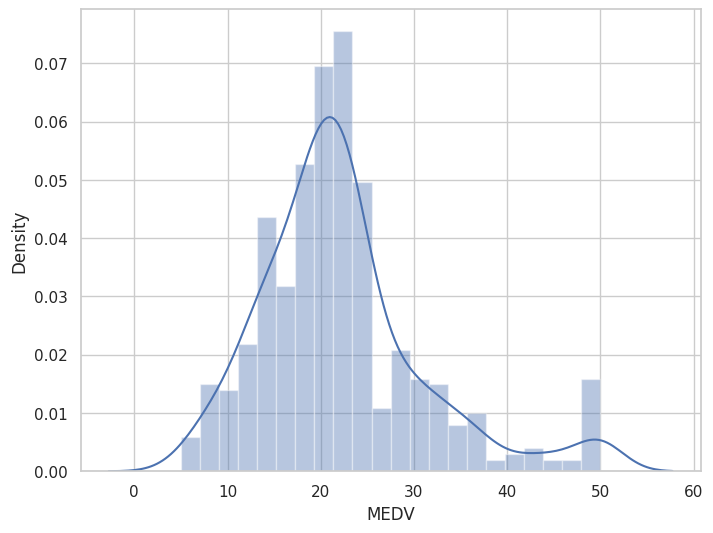

# Hetmap

In [ ]:
plt.figure(figsize=(12, 12))

correlation_matrix = df.corr().round(2)
# annot = True 讓我們可以把數字標進每個格子裡
sns.heatmap(data=correlation_matrix, annot = True)

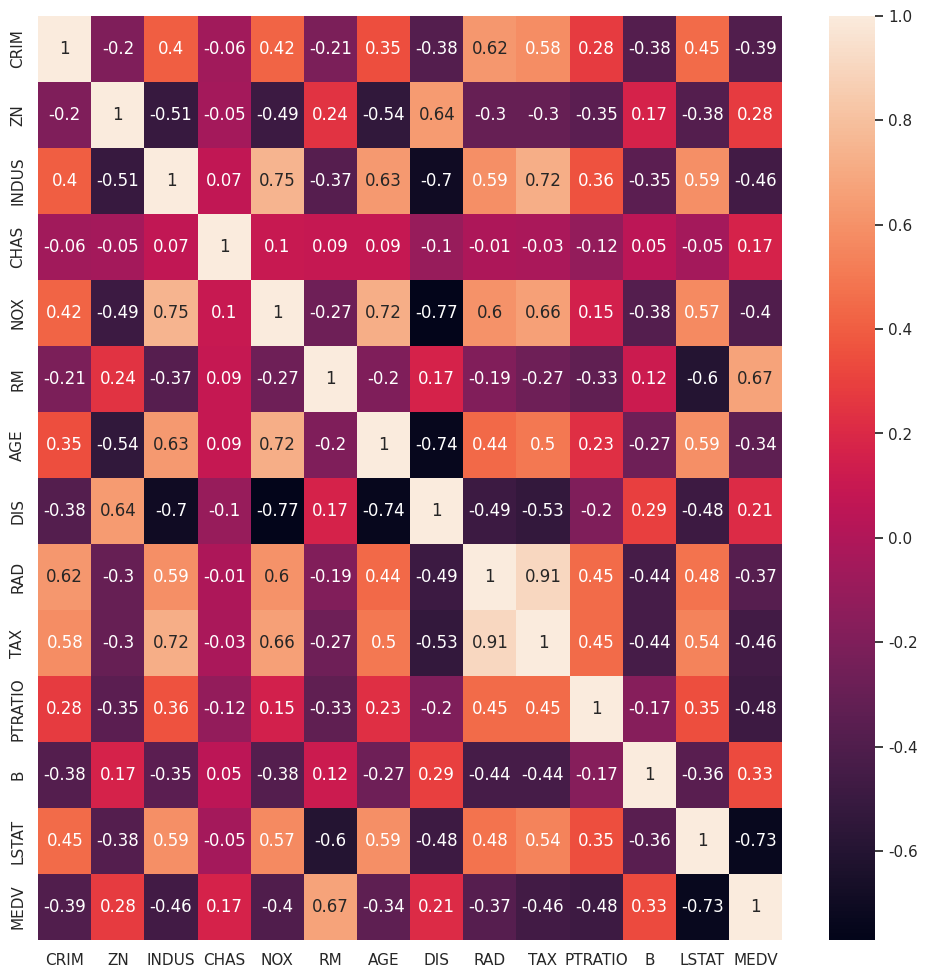

In [ ]:
correlation_matrix = df.corr().abs()

# 取出 'MEDV' 相關的列並將其排序，然後列出前10個高的相關性
top_correlations = correlation_matrix['MEDV'].sort_values(ascending=False).head(10)

print(top_correlations)

可以用LSTAT和RM來做出預測MEDV的模型。再次把這兩個變數跟房價變數的關係畫出來，可以看到兩者和房價變數都接近線性關係

In [ ]:
plt.figure(figsize=(20, 5))
features = ['LSTAT', 'RM']
target = df['MEDV']
for i, col in enumerate(features):
 plt.subplot(1, len(features) , i+1)
 x = df[col]
 y = target
 plt.scatter(x, y, marker='o')
 plt.title(col)
 plt.xlabel(col)
 plt.ylabel('MEDV')

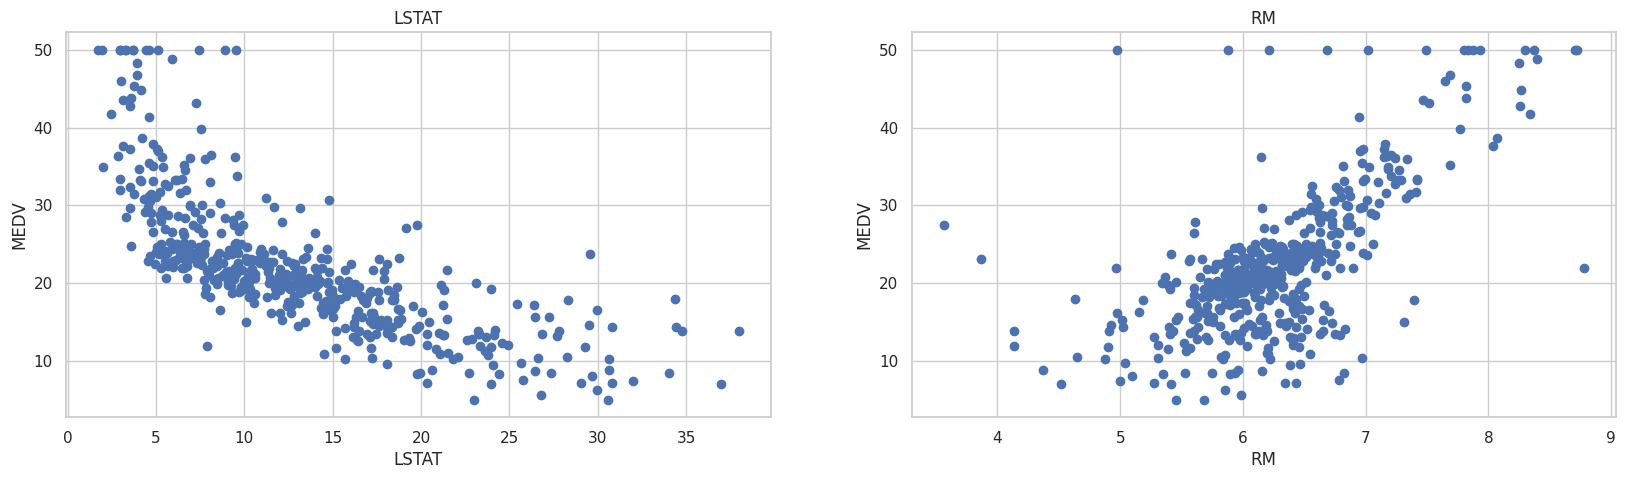

# Split data

In [ ]:
x = df[['LSTAT' ,'RM']]
y = df['MEDV']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

print(X_train.shape) # (393, 2)
print(X_test.shape) # (99, 2)
print(Y_train.shape) # (393,)
print(Y_test.shape) # (99,)

# Modeling

In [ ]:
lreg = LinearRegression()

lreg.fit(X_train ,Y_train)

predictions = lreg.predict(X_test)

# Evaluate

In [ ]:
training_score = lreg.score(X_train, Y_train)
print("訓練集上的模型評分:", training_score)

print('R2:', lreg.score(X_test, Y_test))

mse = mean_squared_error(Y_test, predictions)
print("MSE:", mse)

R2-score讓我們可以知道特徵變數對於目標變數的解釋程度為何，而越接近1代表越準確。在這裡跑出來的結果大約是70%

In [ ]:
# plotting the y_test vs y_pred
Y_pred = lreg.predict(X_test)
plt.scatter(Y_pred, Y_test)
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.show()

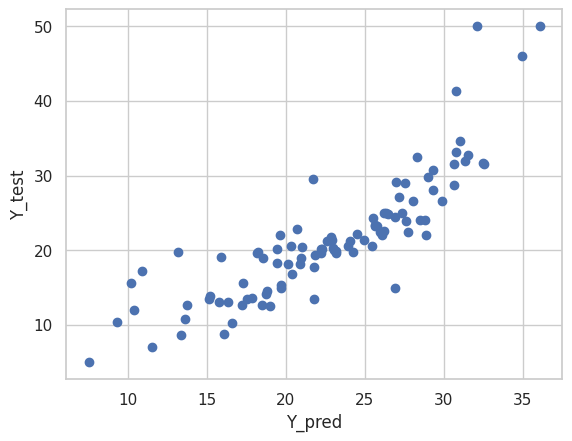

In [ ]:
intercept = lreg.intercept_
print("截距:", intercept)

In [ ]:
coefficients = lreg.coef_
coeff_df = pd.DataFrame(coefficients, X_train.columns, columns=['Coefficient'])
print(coeff_df)

關係式為：

MEDIV = 1.67 ＋ (-0.63) * LSTAT + 4.61 * RM + error

# 結論
*   我們用LSTAT（中低收入戶佔當地居住人口的比例）和RM（房子有幾間房間）藉由多元線性迴歸預測MEDIV（房價）。
*   在其他變數保持不變下，當LSTAT（中低收入戶佔當地居住人口的比例）增加1 unit，MEDIV（房價）就會大約下降0.63 unit。同樣地，當RM（房子有幾間房間）增加1 unit，MEDIV（房價）就會大約上升5.47 unit。看來房子有幾間房間比中低收入戶的比例對於房價有更多的影響力。
*   以上只是簡單的實作，之後可使用圖表的方式來了解各欄特徵在資料集中的分布，深究特徵對Label的影響，並刪除異常值，在用其他模型來做訓練，比較各模型的結果，選出適合的Model





# 參考資料

https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155

# XGBoost

In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, Y_train)

predictions = xgb_model.predict(X_test)

training_score = lreg.score(X_train, Y_train)
print("訓練集上的模型評分:", training_score)

print('R2:', xgb_model.score(X_test, Y_test))

mse = mean_squared_error(Y_test, predictions)
print("Mean Squared Error:", mse)

在不改變特徵與訓練集、測試集的情況下執行XGBRegressor。跑出來的結果大約是71%，略高LinearRegression一些